# Weather Warning - Modelling

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
from sklearn import tree
from IPython.display import Image
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import graphviz
from sklearn.feature_selection import VarianceThreshold

In [2]:
train_data = pd.read_csv('train_data.csv', sep = ',', index_col = 0)

test_data = pd.read_csv('test_data.csv', sep = ',', index_col = 0)

In [3]:
train_data

warning       NOx      PAHs        CO
0         1.0  0.621259  0.778465  0.538144
1         1.0  0.440494  0.511513  0.517684
2         0.0  0.280774  0.405977  0.868359
3         0.0  0.388776  0.605629  0.783053
4         1.0  0.549560  0.559631  0.676406
...       ...       ...       ...       ...
7928      1.0  0.459423  0.396346  0.266821
7929      1.0  0.697799  0.201205  0.334220
7930      1.0  0.599828  0.646196  0.595054
7931      0.0  0.397150  0.158911  0.550449
7932      0.0  0.365401  0.236948  0.448639

[7933 rows x 4 columns]

In the previous notebook we have chosen three attributes with the best results from feature extraction for our training dataset and therefore we will drop other columns from test data.

In [4]:
test_data.drop(columns = ['C2H3NO5', 'SO2', 'PM10', 'CH4', 'station_index'], inplace = True)

test_data

warning       NOx      PAHs       CO
0         1.0   9.69910   7.49238  4.88360
1         1.0   9.15652  10.20579  7.08738
2         0.0   6.49473   5.42752  7.69262
3         1.0   5.48311   5.77877  5.89331
4         0.0   7.80750   5.40122  6.24086
...       ...       ...       ...      ...
1979      1.0  11.61042  10.64788  5.67275
1980      0.0   9.59747   8.57292  8.38775
1981      1.0   7.17228   6.77278  7.05934
1982      0.0   6.22284   4.74361  6.04643
1983      1.0   7.08443   5.41944  6.63079

[1984 rows x 4 columns]

### 1. OneR algorithm

In this chapter we will implement oneR algorithm which also finds the best accuracy split on each column. Based on the previous findings and correletion results there we expect to *NOx* attribute have the best resuls using oneR classification.

In [5]:
def oneR(data, column):
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    best_split = 0
    warning_zero_on_left = False
    
    data = data.sort_values(by = column)
    
    for split_index in range(1, data.shape[0]-1):
        warning_left = data[ :split_index]['warning'].mode()[0]
        warning_right = 1.0 if warning_left == 0.0 else 0.0
        
        warning_compare = [warning_left]*split_index + [warning_right]*(data.shape[0] - split_index)
        accuracy = accuracy_score(data['warning'], warning_compare)
        precision = precision_score(data['warning'], warning_compare)
        recall = recall_score(data['warning'], warning_compare)
        
        if(accuracy > best_accuracy):
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            best_split = split_index
            warning_zero_on_left == warning_compare[0] == 0.0
    
    return [data[best_split:best_split+1][column].values[0], 
            warning_zero_on_left,
            best_accuracy, 
            best_precision, 
            best_recall]
               

In [6]:
def oneR_interpretation(results, column):
    print(20 * "=")
    print("Column name: ", column)
    
    greater_lower = "lower" if results[1] else "greater"
    hypothesis = f"Warning indicator is 0 if the value of {str(column)} is {greater_lower} than {results[0]}" 
    print("The best hypothesis found: ", hypothesis)
    
    print("Accuracy: ", results[2])
    print("Precision: ", results[3])
    print("Recall: ", results[4])
    
    print(20 * "=")

In [7]:
for column in train_data.columns:
    if column == 'warning':
        continue
    
    results = oneR(train_data, column)
    oneR_interpretation(results, column)
    

Column name:  NOx
The best hypothesis found:  Warning indicator is 0 if the value of NOx is greater than 0.3923305750056927
Accuracy:  0.8070086978444473
Precision:  0.8351648351648352
Recall:  0.8909564570152586
Column name:  PAHs
The best hypothesis found:  Warning indicator is 0 if the value of PAHs is greater than 0.3162231110104936
Accuracy:  0.7528047396949452
Precision:  0.7595437262357414
Recall:  0.929289170078154
Column name:  CO
The best hypothesis found:  Warning indicator is 0 if the value of CO is greater than 0.7727722751181456
Accuracy:  0.7067944031261818
Precision:  0.7097440132122214
Recall:  0.9596203944919985


After completing oneR algorithm on every column of our training set we can see that the *NOx* attribute really has the best accuracy followed by *PAHs* and *CO* as last.

### 2. Classificator training and evaluation

Firstly I'll make a pipe for test data as we need only scaler now.

In [8]:
pipe = Pipeline(
    steps = [
        ("Scaling", ColumnTransformer([
        ('ScalingAllExceptWarning', MinMaxScaler(), [1, 2, 3])
        ], remainder = 'passthrough'))
    ]
    
)

test_data = pd.DataFrame(pipe.fit_transform(test_data), columns = ['NOx', 'PAHs', 'CO', 'warning'])

test_data

NOx      PAHs        CO  warning
0     0.604311  0.377203  0.222785      1.0
1     0.552834  0.662530  0.535877      1.0
2     0.300301  0.160073  0.621864      0.0
3     0.204325  0.197009  0.366235      1.0
4     0.424848  0.157308  0.415612      0.0
...        ...       ...       ...      ...
1979  0.785644  0.709018  0.334900      1.0
1980  0.594669  0.490826  0.720621      0.0
1981  0.364582  0.301534  0.531893      1.0
1982  0.274505  0.088157  0.387989      0.0
1983  0.356248  0.159224  0.471009      1.0

[1984 rows x 4 columns]

For easier manipulation we will divide train and test data as its attributes and labels (warning indicator).

In [9]:
train_labels = train_data['warning']
validation_labels = test_data['warning']

train_attributes = train_data[['NOx', 'PAHs', 'CO']]
test_attributes = test_data[['NOx', 'PAHs', 'CO']]

### 2.1 DecisionTreeClassifier
As a first classification method we will use sklearn's DecisionTreeClassifier.

In [10]:
clf = DecisionTreeClassifier()
clf = clf.fit(train_attributes, train_labels)
predicted = clf.predict(test_attributes)

accuracy = accuracy_score(validation_labels, predicted)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8019153225806451


<AxesSubplot: >

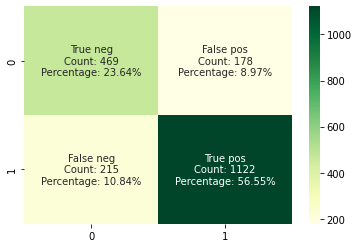

In [11]:
confusion_matrix_results = confusion_matrix(validation_labels, predicted)

groups = ['True neg', 'False pos', 'False neg', 'True pos']

group_value_count = ["Count: {0:0.0f}".format(value) for value in confusion_matrix_results.flatten()]

group_value_percentages = ["Percentage: {0:.2%}".format(value) for value in confusion_matrix_results.flatten()/np.sum(confusion_matrix_results)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groups, group_value_count, group_value_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion_matrix(validation_labels, predicted), annot=labels, fmt='', cmap='YlGn')

In [12]:
print(classification_report(validation_labels, predicted, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       647
           1       0.86      0.84      0.85      1337

    accuracy                           0.80      1984
   macro avg       0.77      0.78      0.78      1984
weighted avg       0.81      0.80      0.80      1984



As we can see, accuracy using DecisionTreeClassifier is not better than it is with oneR algorithm and therefore we will try another classificator too.

In [13]:
dot_data = tree.export_graphviz(clf,
                                out_file = None, 
                                feature_names = test_attributes.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('tree_render',view=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.637639 to fit


'tree_render.png'

In [14]:
Image(filename='tree_render.png') 

### 2.2 RandomForestClassifier

Because classic TreeDecisionClassifier did not perform that well, we will try RandomForestClassifier as well.

In [15]:
clf = RandomForestClassifier()
clf = clf.fit(train_attributes, train_labels)
predicted = clf.predict(test_attributes)

In [16]:
accuracy = accuracy_score(validation_labels, predicted)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8623991935483871


<AxesSubplot: >

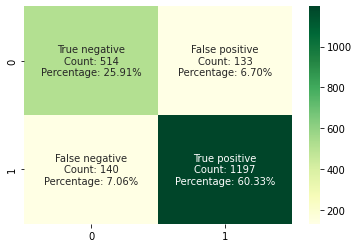

In [17]:
confusion_matrix_results = confusion_matrix(validation_labels, predicted)

groups = ['True negative', 'False positive', 'False negative', 'True positive']

group_value_count = ["Count: {0:0.0f}".format(value) for value in confusion_matrix_results.flatten()]

group_value_percentages = ["Percentage: {0:.2%}".format(value) for value in confusion_matrix_results.flatten()/np.sum(confusion_matrix_results)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groups, group_value_count, group_value_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion_matrix(validation_labels, predicted), annot=labels, fmt='', cmap='YlGn')

As we can see accuracy has increased, RandomForestClassifier gives us less false negative and false positive cases.

However, because random forest classification is based on generating multiple trees, we won't visualize them.

### 2.3 Conclusion

We can directly see that the random forest classifier outperformed the classic decision tree clasifier. Random forest classifier has 86,14%. However, when I look at the image of the decision tree I think the models might be overfitted. We'll try to improve performance with hyperparameter tuning.


In comparison with oneR classificator we wrote in the 1st chapter, even though classic decision tree takes multiple rules into account it did not outperform our oneR classificator. If we compare random forest classifier then we can already see increase in accuracy.

### 3. Hyperparameter tuning

We will try to prune parameters on both decision tree classifier and random forest classifier and choose the best.

### 3.1 DecisionTreeClassifier hyperparameter tuning

In [18]:
criterion = ['gini', 'entropy']
max_depth = [5, 6, 7, 8, 9, 10, 15, 20, None]
min_samples_split = [2, 5, 7, 10, 12, 15, 20, 25, 30, 50, 100]
min_samples_leaf = [1, 2, 5, 6, 7, 8, 9, 10] 

hyper = dict(criterion = criterion,
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

clf = DecisionTreeClassifier()

gs = GridSearchCV(clf, hyper, cv = 3, verbose = 1, n_jobs = -1)

best = gs.fit(train_attributes, train_labels)
print(best)

Fitting 3 folds for each of 1584 candidates, totalling 4752 fits
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 5, 7, 10, 12, 15, 20, 25, 30,
                                               50, 100]},
             verbose=1)


In [19]:
best.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 30}

In [20]:
clf = DecisionTreeClassifier(criterion = 'entropy',
                             max_depth = 7, 
                             min_samples_leaf = 7, 
                             min_samples_split = 30)
clf = clf.fit(train_attributes, train_labels)
predicted = clf.predict(test_attributes)

accuracy = accuracy_score(validation_labels, predicted)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8649193548387096


As we can see, after tuning of hyperparameters of decision tree classifier, we improved accuracy from 79% to 86.5%.

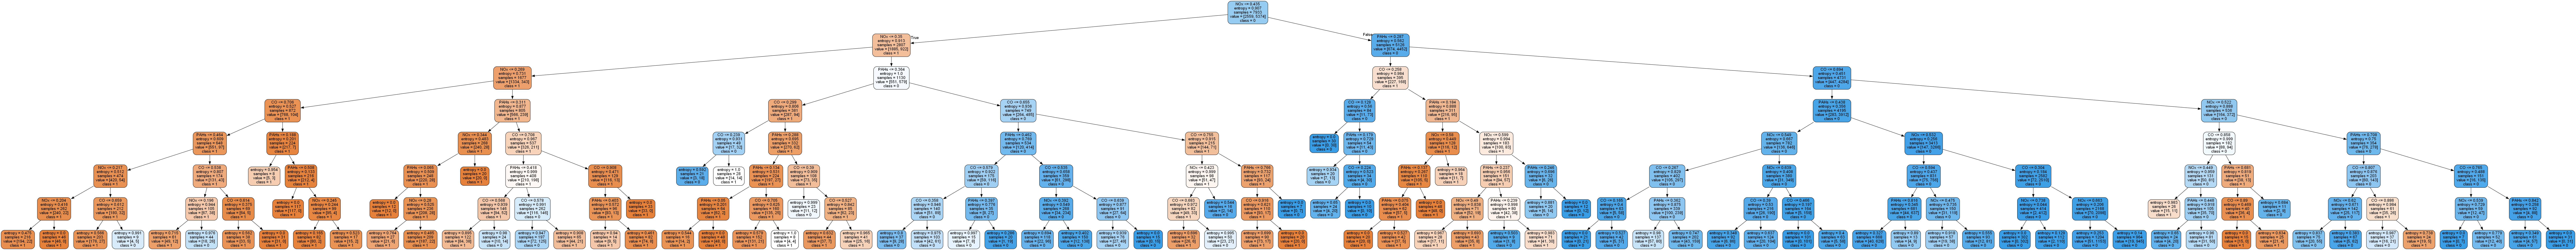

In [21]:
dot_data = tree.export_graphviz(clf,
                                out_file = None, 
                                feature_names = test_attributes.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('tree_render',view=False)
Image(filename='tree_render.png') 

Even from the visualization we can see that now there is much lesser rules for classification. This confirms that our model was seriously overfitted before hyperparameter tuning.

### 3.2 RandomForestClassificator hyperparameter tuning 

In [22]:
criterion = ['gini', 'entropy']
n_estimators = [100, 200, 300]
max_depth = [5, 7, 10, None]
min_samples_split = [2, 5, 10, 20, 30, 50]
min_samples_leaf = [1, 2, 5, 7, 8, 10] 

hyper = dict(criterion = criterion,
             n_estimators = n_estimators, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf
            )

clf = RandomForestClassifier()
gs = GridSearchCV(clf, hyper, cv=3, verbose=1, n_jobs=-1)

best = gs.fit(train_attributes, train_labels)
print(best)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 5, 7, 8, 10],
                         'min_samples_split': [2, 5, 10, 20, 30, 50],
                         'n_estimators': [100, 200, 300]},
             verbose=1)


In [23]:
best.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [24]:
clf = RandomForestClassifier(criterion = 'entropy',
                             max_depth = 10, 
                             min_samples_leaf = 1,
                             min_samples_split = 200, 
                             n_estimators = 100)

clf = clf.fit(train_attributes, train_labels)
predicted = clf.predict(test_attributes)

accuracy = accuracy_score(validation_labels, predicted)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8704637096774194


With tuning parameters of random forest we improved accuracy from 86.44% to 87.15%.

### 4. Evaluation of classification strategy

To try classificate datasets with different outlier and missing value removal methods we will try second dataset where we will remove any outlier values or rows with missing values.

In [25]:
data2 = pd.read_csv('measurements.csv', sep = '\t')

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12145 entries, 0 to 12144
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TEMP       12097 non-null  float64
 1   Pb         12097 non-null  float64
 2   C2H3NO5    12097 non-null  float64
 3   SO2        12097 non-null  float64
 4   CFCs       12097 non-null  float64
 5   warning    12096 non-null  float64
 6   PM10       12097 non-null  float64
 7   latitude   12145 non-null  float64
 8   O3         12097 non-null  float64
 9   PRES       12145 non-null  float64
 10  CH4        12096 non-null  float64
 11  NOx        12097 non-null  float64
 12  PAHs       12095 non-null  float64
 13  longitude  12145 non-null  float64
 14  H2CO       12096 non-null  float64
 15  CO         12097 non-null  float64
 16  PM2.5      12097 non-null  float64
 17  NH3        12097 non-null  float64
dtypes: float64(18)
memory usage: 1.7 MB


In [26]:
def identify_outliers(attribute):
    lower_bound = attribute.quantile(0.25) - 1.5 * stats.iqr(attribute)
    upper_bound = attribute.quantile(0.75) + 1.5 * stats.iqr(attribute)
    
    return attribute[(attribute > upper_bound) | (attribute < lower_bound)]

data2 = data2.dropna().drop_duplicates()

for column in data2.columns:
    if column != 'warning':
        data2.drop(identify_outliers(data2[column]).index, inplace = True)
        
data2.reset_index(drop=True, inplace=True)

data2.describe()

TEMP           Pb      C2H3NO5          SO2         CFCs  \
count  8518.000000  8518.000000  8518.000000  8518.000000  8518.000000   
mean     14.859759    53.670244     0.077229     6.763361    49.960459   
std       9.816257    13.207069     0.048124     1.543407    12.424094   
min     -12.526020    16.819300     0.000000     2.419290    15.471260   
25%       8.024345    44.586290     0.046353     5.676527    41.347797   
50%      14.681120    53.496080     0.061450     6.734025    49.882790   
75%      21.780527    62.748875     0.090002     7.805782    58.501550   
max      42.455450    90.183150     0.265470    11.200450    84.626480   

           warning         PM10     latitude           O3         PRES  \
count  8518.000000  8518.000000  8518.000000  8518.000000  8518.000000   
mean      0.691829     6.600741    28.953492     7.884103  1125.128849   
std       0.461765     1.322594    21.962488     0.977568    43.358150   
min       0.000000     2.797260   -33.592170     5.174340  1050.011720   
25%       0.000000     5.679568    14.537670     7.206423  1087.739098   
50%       1.000000     6.634985    35.066670     7.880400  1125.398670   
75%       1.000000     7.579745    45.350000     8.558385  1162.960777   
max       1.000000     9.214690    65.933810    10.608730  1199.993190   

               CH4          NOx         PAHs    longitude         H2CO  \
count  8518.000000  8518.000000  8518.000000  8518.000000  8518.000000   
mean      8.034622     8.433932     8.650887     7.359474    47.943650   
std       1.933903     1.912892     1.719198    73.926049    11.547965   
min       2.435930     2.921600     3.949350  -156.474320    16.226060   
25%       6.543537     7.104445     7.496218   -71.089770    40.096117   
50%       8.012540     8.523920     8.762940     9.150130    47.822320   
75%       9.510125     9.823762     9.868845    70.911060    55.937602   
max      13.887390    13.869800    13.325060   168.313660    80.043420   

                CO        PM2.5          NH3  
count  8518.000000  8518.000000  8518.000000  
mean      6.775337     7.891720     7.909317  
std       1.273610     0.971415     0.974187  
min       3.312870     5.243340     5.203000  
25%       5.902513     7.239510     7.236600  
50%       6.700585     7.881065     7.908250  
75%       7.574085     8.558248     8.580695  
max      10.280860    10.548840    10.600760

Even tho we have less records, we will try classificators with this dataset how it turns out. We will also try different ratio of train and test data - size of test dataset will be 0.15 of original size.

In [27]:
train_data2, test_data2 = train_test_split(data2, test_size=0.15)

In [28]:
train_data2.reset_index(drop=True, inplace=True)

In [29]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240 entries, 0 to 7239
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TEMP       7240 non-null   float64
 1   Pb         7240 non-null   float64
 2   C2H3NO5    7240 non-null   float64
 3   SO2        7240 non-null   float64
 4   CFCs       7240 non-null   float64
 5   warning    7240 non-null   float64
 6   PM10       7240 non-null   float64
 7   latitude   7240 non-null   float64
 8   O3         7240 non-null   float64
 9   PRES       7240 non-null   float64
 10  CH4        7240 non-null   float64
 11  NOx        7240 non-null   float64
 12  PAHs       7240 non-null   float64
 13  longitude  7240 non-null   float64
 14  H2CO       7240 non-null   float64
 15  CO         7240 non-null   float64
 16  PM2.5      7240 non-null   float64
 17  NH3        7240 non-null   float64
dtypes: float64(18)
memory usage: 1018.2 KB


In [30]:
scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(train_data2[[column for column in train_data2.columns if column != 'warning']]),
                           columns = [column for column in train_data2.columns if column != 'warning'])

# scaled['warning'] = train_data2['warning']

scaled

TEMP        Pb   C2H3NO5       SO2      CFCs      PM10  latitude  \
0    -1.344596  0.354999 -0.720934  1.244290  2.591858 -1.149052  0.967085   
1    -1.966670  0.885118 -0.696823  0.849725 -0.385479  0.126217 -1.090429   
2     2.089872 -0.151118 -0.628231  0.504501  1.052160 -0.379529 -0.928640   
3     1.116355  0.487003 -0.452595 -0.529639 -0.821062 -0.743112  0.056515   
4     0.238825  1.679931 -0.241415 -0.902777  0.838167  0.616710  0.528682   
...        ...       ...       ...       ...       ...       ...       ...   
7235  1.020168  0.415357  0.516212 -1.222976 -0.800165  0.985065  0.348885   
7236 -0.402628  0.859458 -0.583127 -0.780797 -0.265163 -0.535590  0.349732   
7237 -0.612788  0.351528 -0.170953  0.091881 -0.091162 -0.530622  0.041923   
7238 -0.955269 -0.210175 -0.940427 -1.932442  0.397350 -0.794271  0.631443   
7239  0.258393  0.238184  0.883905 -0.853385  0.063108  1.113646 -0.122959   

            O3      PRES       CH4       NOx      PAHs  longitude      H2CO  \
0     2.430946  1.439541  0.433061 -1.215526  2.643127   0.166173  0.920262   
1    -0.305107 -0.643319 -0.993648  0.769670  1.338903  -0.009622  1.182168   
2     0.103375 -0.357259  1.107534 -0.646352 -0.101990  -0.273208 -1.329653   
3    -0.094148  0.362110  0.669622 -0.905041 -0.576338  -1.397146 -1.450094   
4    -1.061926 -0.392234 -0.646944 -0.341256 -0.774255  -1.098286  0.137255   
...        ...       ...       ...       ...       ...        ...       ...   
7235 -0.726102  0.091324  2.725983 -1.242205 -1.352721   1.617551  0.382520   
7236 -0.402660  1.504845  1.240601  1.019919 -0.211257  -0.039150  2.265217   
7237 -0.353484  0.063568  1.331494 -0.820354  0.312951  -1.312123  1.184034   
7238 -1.942197 -0.419826  0.006508 -1.503526  0.181093   0.542488  0.833011   
7239  1.005684 -1.673297 -1.381844  1.382892  1.766009  -1.178583  0.392461   

            CO     PM2.5       NH3  
0    -0.811218 -2.123676 -0.451871  
1     0.226334  0.273448 -0.051226  
2     0.316241  1.350479 -0.033681  
3    -0.179997 -0.147279  0.741161  
4    -1.306039 -1.292145 -0.364338  
...        ...       ...       ...  
7235 -0.497423  1.108586 -0.192197  
7236 -0.011475  0.629058  0.179670  
7237  0.478631 -0.571799  0.193407  
7238  0.132003  0.818899 -0.083843  
7239  0.010020  2.231850  0.703801  

[7240 rows x 17 columns]

In [31]:
scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240 entries, 0 to 7239
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TEMP       7240 non-null   float64
 1   Pb         7240 non-null   float64
 2   C2H3NO5    7240 non-null   float64
 3   SO2        7240 non-null   float64
 4   CFCs       7240 non-null   float64
 5   PM10       7240 non-null   float64
 6   latitude   7240 non-null   float64
 7   O3         7240 non-null   float64
 8   PRES       7240 non-null   float64
 9   CH4        7240 non-null   float64
 10  NOx        7240 non-null   float64
 11  PAHs       7240 non-null   float64
 12  longitude  7240 non-null   float64
 13  H2CO       7240 non-null   float64
 14  CO         7240 non-null   float64
 15  PM2.5      7240 non-null   float64
 16  NH3        7240 non-null   float64
dtypes: float64(17)
memory usage: 961.7 KB


In [32]:
scaled.insert(0, 'warning', train_data2.warning.values, True)

In [33]:
scaled

warning      TEMP        Pb   C2H3NO5       SO2      CFCs      PM10  \
0         1.0 -1.344596  0.354999 -0.720934  1.244290  2.591858 -1.149052   
1         1.0 -1.966670  0.885118 -0.696823  0.849725 -0.385479  0.126217   
2         1.0  2.089872 -0.151118 -0.628231  0.504501  1.052160 -0.379529   
3         0.0  1.116355  0.487003 -0.452595 -0.529639 -0.821062 -0.743112   
4         1.0  0.238825  1.679931 -0.241415 -0.902777  0.838167  0.616710   
...       ...       ...       ...       ...       ...       ...       ...   
7235      0.0  1.020168  0.415357  0.516212 -1.222976 -0.800165  0.985065   
7236      1.0 -0.402628  0.859458 -0.583127 -0.780797 -0.265163 -0.535590   
7237      1.0 -0.612788  0.351528 -0.170953  0.091881 -0.091162 -0.530622   
7238      0.0 -0.955269 -0.210175 -0.940427 -1.932442  0.397350 -0.794271   
7239      1.0  0.258393  0.238184  0.883905 -0.853385  0.063108  1.113646   

      latitude        O3      PRES       CH4       NOx      PAHs  longitude  \
0     0.967085  2.430946  1.439541  0.433061 -1.215526  2.643127   0.166173   
1    -1.090429 -0.305107 -0.643319 -0.993648  0.769670  1.338903  -0.009622   
2    -0.928640  0.103375 -0.357259  1.107534 -0.646352 -0.101990  -0.273208   
3     0.056515 -0.094148  0.362110  0.669622 -0.905041 -0.576338  -1.397146   
4     0.528682 -1.061926 -0.392234 -0.646944 -0.341256 -0.774255  -1.098286   
...        ...       ...       ...       ...       ...       ...        ...   
7235  0.348885 -0.726102  0.091324  2.725983 -1.242205 -1.352721   1.617551   
7236  0.349732 -0.402660  1.504845  1.240601  1.019919 -0.211257  -0.039150   
7237  0.041923 -0.353484  0.063568  1.331494 -0.820354  0.312951  -1.312123   
7238  0.631443 -1.942197 -0.419826  0.006508 -1.503526  0.181093   0.542488   
7239 -0.122959  1.005684 -1.673297 -1.381844  1.382892  1.766009  -1.178583   

          H2CO        CO     PM2.5       NH3  
0     0.920262 -0.811218 -2.123676 -0.451871  
1     1.182168  0.226334  0.273448 -0.051226  
2    -1.329653  0.316241  1.350479 -0.033681  
3    -1.450094 -0.179997 -0.147279  0.741161  
4     0.137255 -1.306039 -1.292145 -0.364338  
...        ...       ...       ...       ...  
7235  0.382520 -0.497423  1.108586 -0.192197  
7236  2.265217 -0.011475  0.629058  0.179670  
7237  1.184034  0.478631 -0.571799  0.193407  
7238  0.833011  0.132003  0.818899 -0.083843  
7239  0.392461  0.010020  2.231850  0.703801  

[7240 rows x 18 columns]

In [34]:
train_attributes2 = scaled.drop(columns = 'warning')
train_labels2 = scaled['warning']

test_attributes2 = test_data2.drop(columns = 'warning')
test_labels2 = test_data2['warning']

In [35]:
test_attributes2.reset_index(drop=True, inplace=True)
test_labels2.reset_index(drop=True, inplace=True)

In [36]:
feature_selector = SelectKBest(k = 6)
feature_selector.fit(train_attributes2, train_labels2)

feature_selector.get_support()

array([False, False,  True,  True, False,  True, False, False, False,
       False,  True,  True, False, False,  True, False, False])

In [37]:
train_attributes2 = train_attributes2[['C2H3NO5', 'SO2', 'PM10', 'NOx', 'PAHs', 'CO']]
train_attributes2

C2H3NO5       SO2      PM10       NOx      PAHs        CO
0    -0.720934  1.244290 -1.149052 -1.215526  2.643127 -0.811218
1    -0.696823  0.849725  0.126217  0.769670  1.338903  0.226334
2    -0.628231  0.504501 -0.379529 -0.646352 -0.101990  0.316241
3    -0.452595 -0.529639 -0.743112 -0.905041 -0.576338 -0.179997
4    -0.241415 -0.902777  0.616710 -0.341256 -0.774255 -1.306039
...        ...       ...       ...       ...       ...       ...
7235  0.516212 -1.222976  0.985065 -1.242205 -1.352721 -0.497423
7236 -0.583127 -0.780797 -0.535590  1.019919 -0.211257 -0.011475
7237 -0.170953  0.091881 -0.530622 -0.820354  0.312951  0.478631
7238 -0.940427 -1.932442 -0.794271 -1.503526  0.181093  0.132003
7239  0.883905 -0.853385  1.113646  1.382892  1.766009  0.010020

[7240 rows x 6 columns]

In [38]:
test_attributes2 = pd.DataFrame(scaler.fit_transform(test_attributes2), columns = test_attributes2.columns)
test_attributes2

TEMP        Pb   C2H3NO5       SO2      CFCs      PM10  latitude  \
0     0.377501  1.203016 -0.762470  0.638849  0.818315  0.262056  0.679264   
1     0.540646  0.746516  1.069486 -1.427075  0.160103  1.223114  0.801458   
2     0.162227 -1.921256 -1.244640  1.273030 -0.080500 -0.977562 -0.010351   
3     0.085017 -1.276736  2.615628 -0.485227 -1.427678  1.606558  0.304298   
4    -0.401335 -0.076852 -0.507167 -0.071308 -0.792265  0.053527 -2.159286   
...        ...       ...       ...       ...       ...       ...       ...   
1273  0.668145 -0.151083 -0.884725 -0.907189  0.268376 -0.735895  0.905760   
1274 -1.435677 -0.212689 -0.475202 -0.011626  0.036073 -0.513499  0.675704   
1275 -1.401058 -0.682232 -0.426010 -1.985316  0.761417 -0.572074 -1.114276   
1276  1.514542 -1.115535 -0.121306  0.398856  1.385518 -0.074035  1.306488   
1277  1.515136 -0.191106 -0.449464  0.892023 -0.241629 -0.816038  0.767452   

            O3      PRES       CH4       NOx      PAHs  longitude      H2CO  \
0     0.635576 -1.611998 -1.784580  0.749346  0.810533  -1.208086 -0.357097   
1     0.199764  0.371031 -0.162166 -0.109508  1.335413   1.040878  0.202574   
2    -0.181117  1.215268  0.945603 -0.736940 -0.199430  -1.235266  0.929576   
3     0.511690 -0.284933 -0.859416 -2.422344 -0.415332   0.014549  0.448582   
4    -0.018818 -0.128205  0.935830 -0.416475 -0.636832   2.160968  1.061355   
...        ...       ...       ...       ...       ...        ...       ...   
1273 -0.638063  0.202517 -0.038552  0.488965  0.347582  -0.004554  0.000085   
1274  0.577432  0.061891  0.354833  1.348376  0.734769  -0.025896  1.552600   
1275  0.474568  1.409727  0.693857  0.463168  0.040289   0.086623 -1.045676   
1276  1.618717  1.001468 -0.912561  0.043383 -0.164459  -0.186914 -0.405534   
1277 -1.075329  0.190794  0.322594  0.919942 -1.533026   0.045298 -1.265325   

            CO     PM2.5       NH3  
0    -0.886983  0.466482 -0.268033  
1     1.346354  1.255221 -1.478191  
2    -0.313842 -0.783541  1.460789  
3     0.966377  0.208618 -1.018070  
4     0.170355 -0.898148  1.262402  
...        ...       ...       ...  
1273  1.133219  0.465787 -0.861215  
1274 -0.256929 -1.341416  0.567717  
1275  1.245266  1.224233 -0.369042  
1276 -0.912067 -0.319910 -1.474384  
1277 -0.105031  0.824974 -0.541246  

[1278 rows x 17 columns]

Now that we have next dataset ready we will again try to use classificators - we will again compare random forest classificator and decision tree classificator.

In [39]:
train_attributes2 = pd.read_csv('train_attributes2.csv', sep = ',', index_col = 0)
train_labels2 = pd.read_csv('train_labels2.csv', sep = ',', index_col = 0)

test_attributes2 = pd.read_csv('test_attributes2.csv', sep = ',', index_col = 0)
test_labels2 = pd.read_csv('test_labels2.csv', sep = ',', index_col = 0)

In [40]:
clf = DecisionTreeClassifier()
clf = clf.fit(train_attributes2, train_labels2)
predicted = clf.predict(test_attributes2)

accuracy = accuracy_score(test_labels2, predicted)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8826291079812206


<AxesSubplot: >

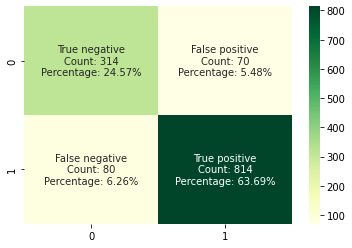

In [41]:
confusion_matrix_results = confusion_matrix(test_labels2, predicted)

groups = ['True negative', 'False positive', 'False negative', 'True positive']

group_value_count = ["Count: {0:0.0f}".format(value) for value in confusion_matrix_results.flatten()]

group_value_percentages = ["Percentage: {0:.2%}".format(value) for value in confusion_matrix_results.flatten()/np.sum(confusion_matrix_results)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groups, group_value_count, group_value_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion_matrix(test_labels2, predicted), annot=labels, fmt='', cmap='YlGn')

In [42]:
clf = RandomForestClassifier()
clf = clf.fit(train_attributes2, train_labels2)
predicted = clf.predict(test_attributes2)

accuracy = accuracy_score(test_labels2, predicted)
print(f"Accuracy: {accuracy}")

C:\Users\majoa\AppData\Local\Temp\ipykernel_17268\3348579637.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(train_attributes2, train_labels2)


Accuracy: 0.9327073552425665


<AxesSubplot: >

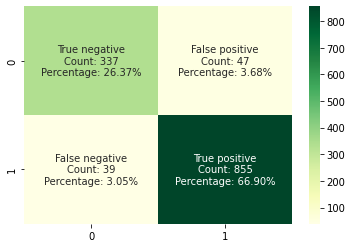

In [43]:
confusion_matrix_results = confusion_matrix(test_labels2, predicted)

groups = ['True negative', 'False positive', 'False negative', 'True positive']

group_value_count = ["Count: {0:0.0f}".format(value) for value in confusion_matrix_results.flatten()]

group_value_percentages = ["Percentage: {0:.2%}".format(value) for value in confusion_matrix_results.flatten()/np.sum(confusion_matrix_results)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groups, group_value_count, group_value_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion_matrix(test_labels2, predicted), annot=labels, fmt='', cmap='YlGn')

After using default classificator settings we can see that random forest has better accuracy again, however it has even better accuracy than we had on our first train dataset - therefore some steps we did in previous notebook during preprocessing data maybe were not the most the best.

### 4.4 Hyperparameter tuning

### 4.4.1 Decision tree classifier hyperparameter tuning

In [ ]:
criterion = ['gini', 'entropy']
max_depth = [5, 6, 7, 8, 9, 10, 15, 20, None]
min_samples_split = [2, 5, 7, 10, 12, 15, 20, 25, 30, 50, 100]
min_samples_leaf = [1, 2, 5, 6, 7, 8, 9, 10] 

hyper = dict(criterion = criterion,
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

clf = DecisionTreeClassifier()

gs = GridSearchCV(clf, hyper, cv = 3, verbose = 1, n_jobs = -1)

best = gs.fit(train_attributes2, train_labels2)
print(best)

Fitting 3 folds for each of 1584 candidates, totalling 4752 fits


In [ ]:
best.best_params_

In [ ]:
clf = DecisionTreeClassifier(criterion = 'entropy',
                            max_depth = 9,
                            min_samples_leaf = 7,
                            min_samples_split = 7)
clf = clf.fit(train_attributes2, train_labels2)
predicted = clf.predict(test_attributes2)

accuracy = accuracy_score(test_labels2, predicted)
print(f"Accuracy: {accuracy}")

Hyperparameter tuning of decisiontreeclassifier has increased the accuracy to 91.15%.

### Random forest classificator hyperparameter tuning

In [ ]:
n_estimators = [100, 200]
max_depth = [5, 7, 10, None]
min_samples_split = [2, 5, 10, 20, 30, 50]
min_samples_leaf = [1, 2, 5, 7, 10] 

hyper = dict(n_estimators = n_estimators, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf
            )

clf = RandomForestClassifier()
gs = GridSearchCV(clf, hyper, cv=3, verbose=1, n_jobs=-1)

best = gs.fit(train_attributes2, train_labels2)
print(best)

In [ ]:
best.best_params_

In [ ]:
clf = RandomForestClassifier(max_depth = 9,
                            min_samples_leaf = 1,
                            min_samples_split = 5,
                            n_estimators = 200)
clf = clf.fit(train_attributes2, train_labels2)
predicted = clf.predict(test_attributes2)

accuracy = accuracy_score(test_labels2, predicted)
print(f"Accuracy: {accuracy}")

With hyperparameter tuning of randomForestClassifier we have increased the accuracy to the 91.94%.


### 5. Conclusion

We have implemented oneR algorithm and tried other classification algorithms as decision tree and random forest classification. With our previous train data we have got to accuracy of 87.15% with random forest classificator. In 4th chapter we tried to make different train dataset with different approaches and it did prove well, it outperformed our first dataset. It's best accuracy is again with random forest classifier - 91.94%. 

In [3]:
train_attributes2 = pd.read_csv('train_attributes2.csv', sep = ',', index_col = 0)
train_labels2 = pd.read_csv('train_labels2.csv', sep = ',', index_col = 0)

test_attributes2 = pd.read_csv('test_attributes2.csv', sep = ',', index_col = 0)
test_labels2 = pd.read_csv('test_labels2.csv', sep = ',', index_col = 0)

In [7]:
test_attributes2

C2H3NO5       SO2      PM10       NOx      PAHs        CO
0    -0.285283  0.082536  0.222048  0.052620 -0.422613  0.753395
1     0.215795  0.505600  0.430774  0.065057  1.054437 -1.935334
2    -0.718676  0.279528 -0.791907  0.619872  0.697237 -1.874712
3    -0.115758 -0.899111  0.159593  2.386819  0.553655 -0.952796
4    -0.613712 -0.319893 -0.402536  1.273460  1.776916 -1.831394
...        ...       ...       ...       ...       ...       ...
1273 -1.335964  0.044712 -1.053654  1.229415  0.402189 -0.802098
1274 -0.532490  0.836640 -1.035655  1.064507  0.560427  0.286233
1275  0.051893 -0.772212  0.177112  0.568142 -0.287486  0.113764
1276  0.667099 -0.656149  1.034232  0.411070 -0.200587  0.957374
1277 -0.195522  2.502934 -0.797444  0.447746 -0.292177 -1.684129

[1278 rows x 6 columns]